In [1]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchmetrics.classification import MultilabelAUROC
from collections import Counter
from d2l import torch as d2l
import pandas as pd
import numpy as np
import yaml
import os
import json
import sys

sys.path.append("C:\\Users\\niels\\Documents\\Github\\Birds-NL-PAM\\")

import config as cfg

from Dataset import EmbeddingDataset
from Classifier import Classifier
from utils import stitchup
#from utils import stitchup, mixup
#from model import Classifier, EmbeddingDataset, EarlyStopper, MixUpDataset

#cfg = yaml.safe_load(open("C:/Users/niels/Documents/Github/Sovon-PAM/config.yml"))
DIR = cfg.DATASET_DIR

In [2]:
def accuracy(y_hat, y):
    return sum(torch.where(torch.amax(y, axis=1) > 0.1,
        torch.where(torch.argmax(y_hat, axis=1) == torch.argmax(y, axis=1), 1, 0),
        torch.where(torch.amax(y_hat, axis=1) < 0.5, 1, 0)
    ))
    #return sum(torch.where(y_hat[torch.argmax(y, axis=1)] > 0.5, 1, 0))


def evaluate_val_data(net: torch.nn.Module, val_iter, loss, device):
    # set network to evaluation mode (don't apply dropout)
    net.eval()
    
    metric = d2l.Accumulator(3)
    for i, (X, y) in enumerate(val_iter):
        # send batch samples to GPU
        X, y = X.to(device), y.to(device)
        # make predictions
        y_hat = net(X)
        # compute loss
        l = loss(y_hat, y)
        # store metrics
        with torch.no_grad():
            metric.add(accuracy(y_hat, y), l, X.shape[0])

    val_acc = metric[0] / metric[2]
    val_loss = metric[1] / metric[2]
    
    return val_acc, val_loss


def train(net: torch.nn.Module, train_iter, val_iter, n_classes, n_epochs=100, lr=0.001, device=d2l.try_gpu()):
    print('training on', device)
    net.to(device)
    
    decay_steps = len(train_iter) * n_epochs
    n_batches = len(train_iter)

    #optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=0.01, amsgrad=False)
    #early_stopper = EarlyStopper(patience=5, min_delta=0)
    
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=decay_steps, eta_min=0, last_epoch=-1, verbose=False)
    loss = torch.nn.BCELoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, n_epochs], ylim=[0,1], legend=['train acc', 'test acc'])
    timer = d2l.Timer()
    
    train_accs  = []
    val_accs = []
    for epoch in range(n_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples, no. of calls
        metric = d2l.Accumulator(2)
        #auroc = MultilabelAUROC(num_labels=n_classes, average="macro")
        # set network to training mode
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            X, y = stitchup(X, y, 1)
            # send batch samples to GPU
            X, y = X.to(device), y.to(device)
            # reset gradients
            optimizer.zero_grad()
            # make predictions
            y_hat = net(X)
            # compute loss
            l = loss(y_hat, y)
            # compute gradients
            l.backward()
            # update weights
            optimizer.step()
            # store metrics
            with torch.no_grad():
                metric.add(accuracy(y_hat, y), X.shape[0])
                #auroc.update(y_hat, torch.where(y > 0.1, 1, 0))
                
            timer.stop()
            scheduler.step()

        train_acc = metric[0] / metric[1]
        #train_auc = auroc.compute().cpu()
        val_acc, val_loss = evaluate_val_data(net, val_iter, loss, device)
        animator.add(epoch + 1, (train_acc, val_acc))
        #plt.show()
        #val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        #if early_stopper.early_stop(val_loss):  
        #    print(val_losses)
        #    break
    print(train_accs)
    print(val_accs)
    print(f'{metric[1] * n_epochs / timer.sum():.1f} examples/sec 'f'on {str(device)}')

[0.1343558282208589, 0.5238496932515337, 0.6513803680981595, 0.6906441717791411, 0.7147239263803681, 0.7140337423312884, 0.7246165644171779, 0.7358128834355828, 0.7333588957055215, 0.7445552147239264, 0.7501533742331289, 0.7545245398773006, 0.7538343558282209, 0.7562883435582822, 0.7636503067484662, 0.7680214723926381, 0.7691717791411042, 0.7749233128834356, 0.7791411042944786, 0.7799846625766871, 0.7835889570552147, 0.7799079754601227, 0.7854294478527607, 0.7891104294478528, 0.7885736196319019, 0.7872699386503067, 0.7868865030674846, 0.7973159509202454, 0.7953987730061349, 0.7907208588957055]
[0.5288343558282208, 0.718558282208589, 0.7745398773006135, 0.782361963190184, 0.7973926380368098, 0.7996932515337424, 0.8053680981595092, 0.803680981595092, 0.8081288343558283, 0.80920245398773, 0.804601226993865, 0.8096625766871166, 0.8124233128834356, 0.807361963190184, 0.8121165644171779, 0.8153374233128834, 0.8131901840490797, 0.818558282208589, 0.8208588957055215, 0.8162576687116564, 0.8145

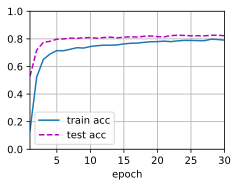

In [3]:
species_list = pd.read_csv(cfg.SPECIES_FILE_PATH, index_col=0)
classes = species_list['latin_name'].values.tolist()

p_secondary = 0.9
alpha = 0.1
batch_size = 64
dropout = 0.1

train_ds = EmbeddingDataset(classes, DIR, 'train', min_samples=80, p_secondary=p_secondary, alpha=alpha)
val_ds = EmbeddingDataset(classes, DIR, 'val', min_samples=20, p_secondary=p_secondary, alpha=alpha)

#train_sampler = torch.utils.data.sampler.WeightedRandomSampler(train_ds.get_sample_weights(), len(train_ds), replacement=True)
#val_sampler = torch.utils.data.sampler.WeightedRandomSampler(val_ds.get_sample_weights(), len(val_ds), replacement=True)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=True, drop_last=False)

sample_x, sample_y = next(iter(train_dl))
n_inputs = sample_x.shape[-1]
n_classes = sample_y.shape[-1]

net = Classifier(n_inputs, n_classes, n_hidden=512, dropout=dropout)

train(net, train_dl, val_dl, n_classes, n_epochs=30, lr=0.001)

In [4]:
model_path = 'C:/Users/niels/Documents/Github/Birds-NL-PAM/train/model6.pt'
torch.save(net, model_path)

In [ ]:
#model_path = 'C:/Users/niels/Documents/Github/Sovon-PAM/trainer/model3.pt'

model = torch.load(model_path).to(d2l.try_gpu())
embeddings = np.load(DIR + "test/embeddings/V4_stbn1_20220708_033456.npy")

embedding = torch.from_numpy(np.array([embeddings[100]], dtype=np.float32))
print(len(embedding))
pred = model(embedding.to(d2l.try_gpu()))
print(len(pred[0]))
print(torch.amax(pred.cpu()))
pred_class = torch.argmax(pred.cpu())

print(pred_class)
species_list.iloc[[pred_class]]

In [44]:
y = [[1.0,0.],[0.,1.]]
y_hat = [[0.0,0.0],[0.0,0.0]]
accuracy(torch.Tensor(y_hat), torch.Tensor(y))

tensor([[1., 0.],
        [1., 0.]]) tensor([[0, 1],
        [1, 0]])
